<a href="https://colab.research.google.com/github/kiryu-3/Prmn2023/blob/main/Python/Python_Machine/Machine_Learning_8_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 分類モデルの評価指標ー実践編

In [ ]:
# 最初にインポートしてください
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso, LinearRegression, LogisticRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error, r2_score, log_loss
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.model_selection import KFold, RepeatedKFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml, load_iris
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, label_binarize
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
import statsmodels.api as sma
from scipy.stats import hmean

今回は、**タイタニック号**という大型乗客船の沈没事故に際して、  
どの人が生存/死亡したのかをデータセットを使って予測します。

以前ロジスティック回帰を行った際は、モデルの評価を行わなかったので、  
今回はロジスティック回帰のモデルの評価を行います。



Kaggleというデータコンペサイトにも同じデータセットがあります（リンクは[こちら](https://www.kaggle.com/c/titanic)）。  
別のノートブックでは分析結果をKaggleに提出してscoreを出すところまでやろうと思います。

[ヒノマルクさんのこちらの記事](https://www.hinomaruc.com/titanic-dataset-analytics-1/)にも、タイタニックデータセットの説明があります。

## 0.モデル作成の手順

モデル作成を行うまでは、以下のような一連の手順を踏むと良いようです。

1. 問題を定義する<small>（何を知ればよいかを決める）</small>
2. データを入手する<small>（データを入手する）</small>
3. データを確認する<small>（実際にデータを確認・分析して項目同士の関係性や影響の有りそうな項目を見つける）</small>
4. データを整備する<small>（確認した結果、整備すべきものを整備する）</small>
4. 学習用・テスト用データに分割する<small>（モデル作成後に精度を検証するためデータ全体を分割しておきテスト用データを確保する）</small>
5. モデルを構築する<small>（適切な手法を選択しモデルを作成する）</small>
6. モデルを評価する<small>（退避させておいたテスト用データを作成したモデルに読み込ませて結果が正しく出るか精度を確認する）</small>

## 1.問題を定義する

今回から取り組む問題を整理すると、以下のようになります。

> <font color=blue>タイタニック号乗客のデータ項目から、その乗客の生存/死亡(survival=0 or 1)を分類する</font>

データ項目からその乗客のsurvivalが0であるか1であるかを分類するようなモデル</b>を作成していきます。<br>


##2.データを用意する

### 2-1.データを入手する


今回は、seabornのサンプル用データセット"titanic"を利用します。

データセットは、pandas.DataFrameオブジェクトとして取得することができます。

（参考サイト：[こちら](https://biotech-lab.org/articles/1408#i)）

In [ ]:
df = sns.load_dataset('titanic')
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


"titanic"のデータの説明は以下の通りです。

- survival : 生存 or 死亡 (0=死亡、1=生存)
- pclass : チケットクラス (1=上層クラス、2=中級クラス、3=下層クラス)
- sex : 性別 (male=男性、female=女性)
- age : 年齢
- sibsp : タイタニックに同乗している兄弟/配偶者の数
- parch : タイタニックに同乗している親/子供の数
- fare : 料金
- embarked : 出港地 (C=Cherbourg、Q=Queenstown、S=Southampton)

seabornのタイタニックデータフレームでは、以下の情報も付け加えられています。  
(deck以外は基本項目から求めることのできる項目です)

- who : 男性 or 女性
- adult_male : 成人男性であるかどうか
- deck : 乗船していたデッキ
- embark_town : 出港地
- alive : 生存したかどうか
- alone : 一人であったかどうか

## 3.データを確認する

[ヒノマルクさん](https://www.hinomaruc.com/tag/titanic/?order=asc)のブログでは、より詳細にデータの確認を行っています。  
- [データ俯瞰（表形式）](https://www.hinomaruc.com/titanic-dataset-analytics-2-1/)- データの理解中心  
- [データ俯瞰（表形式）](https://www.hinomaruc.com/titanic-dataset-analytics-2-2/)- 目的変数と説明変数の関係性中心
- [データ俯瞰（グラフ形式）](https://www.hinomaruc.com/titanic-dataset-analytics-2-3/)- 目的変数と説明変数の関係性中心


## 4.データを整備する

### 4-1.データのクレンジング




欠損値の処理を行います。

In [ ]:
df = df.drop('deck', axis=1)

# inplace=Trueとすると、代入しなくても上書きしてくれる
df['embarked'].fillna('S', inplace=True)
df['embark_town'].fillna('Southampton', inplace=True)

# "Pclass"ごとの"age"の平均値を計算し、それを新しい列として追加
age_mean_by_pclass = df.groupby('pclass')['age'].mean()
print(age_mean_by_pclass)
print("----------------")
df['age_mean_by_pclass'] = df['pclass'].map(age_mean_by_pclass)

# "age"が欠損している場合、対応する"Pclass"の平均値で欠損を埋める
df['age'].fillna(df['age_mean_by_pclass'], inplace=True)

# 不要な"age_mean_by_pclass"列を削除
df.drop(columns=['age_mean_by_pclass'], inplace=True)

df.info()

pclass
1    38.233441
2    29.877630
3    25.140620
Name: age, dtype: float64
----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          891 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     891 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  embark_town  891 non-null    object  
 12  alive        891 non-null    object  
 13  alone        891 non-null    bool    
dtypes: bool(2), category(1), float64(2), int64(4), object(5)
memory usage: 79.4+ KB


どうやら欠損値はなくなったようです。

### 4-2.データの整理



#### 1.不要なデータ項目の削除


不要なデータ項目を削除します。

In [ ]:
# 複数の列を一度に削除
df = df.drop(['who', 'alive', 'embark_town', 'class', "adult_male", "alone"], axis=1)
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


データがかなりすっきりしてきました。

#### 2.データ型の変更

"pclass"カラムの値はint型となっていますが、
 数値型というよりは名義型のデータであるので文字型に変換します。

In [ ]:
df['pclass'] = df['pclass'].apply(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  891 non-null    int64  
 1   pclass    891 non-null    object 
 2   sex       891 non-null    object 
 3   age       891 non-null    float64
 4   sibsp     891 non-null    int64  
 5   parch     891 non-null    int64  
 6   fare      891 non-null    float64
 7   embarked  891 non-null    object 
dtypes: float64(2), int64(3), object(3)
memory usage: 55.8+ KB


#### 3.ダミー変数の作成処理

one-hotエンコーディングを行います。

In [ ]:
# one-hotエンコーディング
df = pd.get_dummies(df, columns=['pclass', 'sex', 'embarked'], drop_first=True)
df.head()

,survived,age,sibsp,parch,fare,pclass_2,pclass_3,sex_male,embarked_Q,embarked_S
0,0,22.0,1,0,7.2500,0,1,1,0,1
1,1,38.0,1,0,71.2833,0,0,0,0,0
2,1,26.0,0,0,7.9250,0,1,0,0,1
3,1,35.0,1,0,53.1000,0,0,0,0,1
4,0,35.0,0,0,8.0500,0,1,1,0,1


これでようやく、全てのデータ項目が数値になりました。

### 4-3.そのほかのデータの加工

[ヒノマルクさんの記事](https://www.hinomaruc.com/titanic-dataset-analytics-3-1/)にもありますが、  
ほかにも以下のような加工をすることで、モデルの精度向上が期待できます。



- 外れ値処理

  - 外れ値かどうかを判断して除外するかどうかを検討する。

- 特徴量エンジニアリング

  - 新しい意味を持つ変数を作成する。
  - より説明力がある変数が作成できたり、変数の数を減らせる可能性がある。
  
- 変数選択

  - モデリングに必要なさそうな変数は除外する。
  - 計算量を減らせたり多重共線性を防げる可能性がある。

## 5.学習用・テスト用データに分割する

hold-out法で、整備したデータを  
「学習用データ」と「テスト用データ」に分割します。

In [ ]:
# 目的変数に"survived"、説明変数にそれ以外の6つのカラムを指定
X = df.drop('survived', axis=1)
y = df['survived']

# 学習データとテストデータ分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## 6.モデルを作成する

前処理とモデルを一つのオブジェクトとして扱うことができるpipelineを使って、  
いよいよ、ロジスティック回帰を行っていきます。

In [ ]:
# Pipelineを定義
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # データの標準化
    ('model', LogisticRegression(penalty='none'))  # ロジスティック回帰モデル
])
pipeline.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LogisticRegression(penalty='none'))])

それぞれのラベルの分類結果を取得したいときは、  
**`.predict(X)`**を使います。

In [ ]:
y_pred = pipeline.predict(X_test)
y_pred[:5]

array([0, 0, 0, 1, 1])

それぞれのラベルの確率$p(X)$を取得したいときは、  
**`.predict_proba(X)`**を使います。

In [ ]:
y_pred_proba = pipeline.predict_proba(X_test)
print(pipeline.classes_)  # クラスの値
print(pipeline.named_steps['model'].intercept_)  # 切片の値
print(y_pred_proba[:5])  # それぞれの出現確率

[0 1]
[-0.63385095]
[[0.84176752 0.15823248]
 [0.89365205 0.10634795]
 [0.93050528 0.06949472]
 [0.07219748 0.92780252]
 [0.33250492 0.66749508]]


係数の値を確認してみましょう。

In [ ]:
# ロジスティック回帰モデルの係数を取得
coef = pipeline.named_steps['model'].coef_[0]

# 係数をカラムと対応づけて表示
print(pd.Series(coef, index=X.columns))

age          -0.596742
sibsp        -0.475050
parch        -0.089960
fare          0.068937
pclass_2     -0.399697
pclass_3     -1.135820
sex_male     -1.311075
embarked_Q   -0.005554
embarked_S   -0.196981
dtype: float64


#### 交差エントロピーの導出

学習(fit)時には、学習データにおける交差エントロピーを最小にするように、  
パラメータ$\theta$を求めています。

その後、テストデータを使って交差エントロピーを求めたい場合、  
`log_loss(y_test, y_pred_proba)`を使って求めることができます。

In [ ]:
from sklearn.metrics import log_loss
log_loss(y_test, y_pred_proba)

4.3905703779997065

##  7.モデルを評価する

### 混同行列の表示

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix(y_test, y_pred, labels=[1, 0])

array([[115,  48],
       [ 48, 235]])

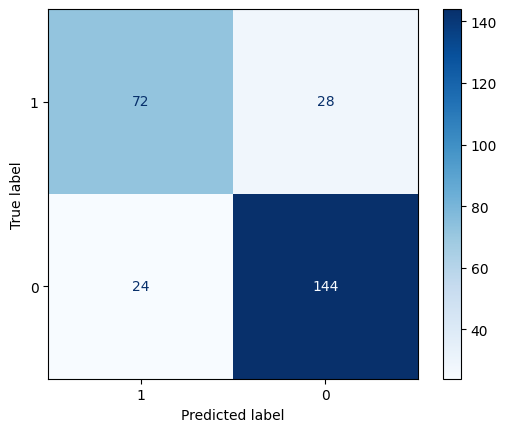

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels=[1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])
disp.plot(cmap=plt.cm.Blues)

### Accuracy,Precision,Recall,Specificity,F値の導出

In [ ]:
# classes
print(pipeline.classes_)

# Accuracy
print(f"Accuracy：{accuracy_score(y_test, y_pred)}")

# precision
print(f"precision：{precision_score(y_test, y_pred)}")

# recall
print(f"recall：{recall_score(y_test, y_pred)}")

# Specificity
print(f"Specificity：{recall_score(np.array(y_test)!=1, np.array(y_pred)!=1)}")

# F1
print(f"F値：{f1_score(y_test, y_pred)}")

[0 1]
Accuracy：0.8059701492537313
precision：0.75
recall：0.72
Specificity：0.8571428571428571
F値：0.7346938775510204


### Precision-Recall Curveの描画

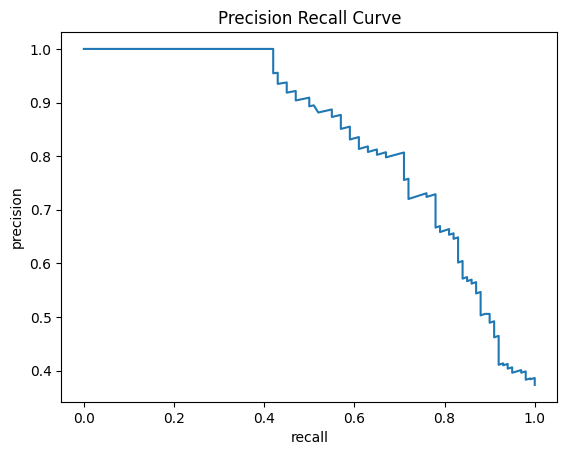

In [ ]:
# 陽性の確率だけが必要なので[:, 1]をして陰性の確率を落とす
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba[:, 1])

plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision Recall Curve')
plt.show()

### Precision,Recall,F値の推移

163th threshold(=0.5704644803) is the highest f1 score = 0.76


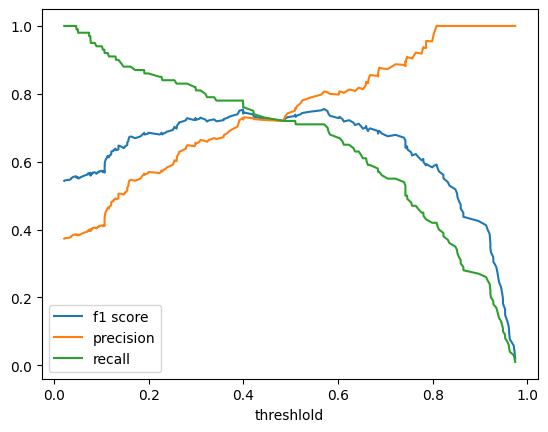

In [ ]:
# それぞれのprecisionとrecallにおけるF値(調和平均)を計算
f1_scores = [hmean([p, r]) for p, r in zip(precision, recall)]

plt.plot(thresholds, f1_scores[:-1], label='f1 score')
plt.plot(thresholds, precision[:-1], label='precision')
plt.plot(thresholds, recall[:-1], label='recall')
plt.xlabel('threshlold')
plt.legend()
print(f'{np.argmax(f1_scores)}th threshold(={thresholds[np.argmax(f1_scores)]:.10f}) is the highest f1 score = {np.max(f1_scores):.2f}')

ロジスティック回帰ですが、しきい値を0.5ではなく、  
f値が最大となった0.570とすると、さらなる精度向上が見込めるかもしれません。

### ROCの描画

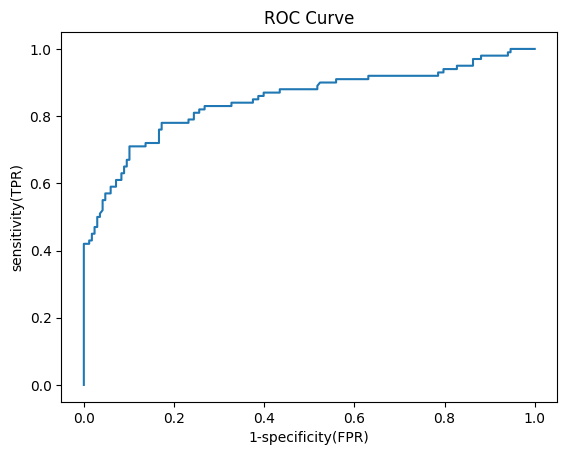

In [ ]:
from sklearn.metrics import roc_curve

# 陽性の確率だけが必要なので[:, 1]をして陰性の確率を落とす
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])
# 描画
plt.plot(fpr, tpr)
plt.xlabel('1-specificity(FPR)')
plt.ylabel('sensitivity(TPR)')
plt.title('ROC Curve')
plt.show()

### AUCの計算

In [ ]:
from sklearn.metrics import auc
auc(fpr, tpr)

0.8486904761904762

かなり精度がいいモデルになったようです。